In [ ]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install numpy==1.15.4 --user
!{sys.executable} -m pip install keras==2.1.3 --user
!{sys.executable} -m pip install pandas==0.23.4 --user
!{sys.executable} -m pip install scikit-image==0.14.1 --user
!{sys.executable} -m pip install scikit-learn==0.19.0 --user
!{sys.executable} -m pip install tensorflow --user



In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import keras
import skimage
import tensorflow
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import skimage.morphology as morp
from skimage.filters import rank

%matplotlib inline

assert pd.__version__ == '0.23.4'
assert np.__version__ == '1.15.4'
assert keras.__version__ == '2.1.3'
assert skimage.__version__ == '0.14.1'
assert sklearn.__version__ == '0.19.2'
assert tensorflow.__version__ == '1.12.0'


Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
train = pd.read_csv("../data/train.csv")
train_labels = train["Label"].values
train = train.sort_values("Img_Name").reset_index(drop=True)
train.head()

,Img_Name,Top,Left,Width,Height,Label
0,01-05 10.15.27_2.jpg,248,422,17,24,Speed Limit 60
1,01-05 10.15.38.jpg,360,765,45,60,Speed Limit 40
2,01-07 11.34.55.jpg,111,958,95,148,Speed Limit 20
3,01-07 16.39.19.jpg,282,1113,55,78,Speed Limit 40
4,01-09 01.46.39.jpg,357,872,30,31,Speed Limit 50


In [5]:
# Load all images. 

import os
import skimage.data
def load_data(data_dir):
    images = []
    
    file_names = sorted([os.path.join(data_dir, f)
                         for f in os.listdir(data_dir) if f.endswith(".jpg")])
    
    for f in file_names:
        images.append(skimage.data.imread(f)) #as_gray=True))

    return images

%time images = load_data('../data/object-detection-train')
print(len(images))

CPU times: user 21.6 s, sys: 1.88 s, total: 23.5 s
Wall time: 26.2 s
467


In [ ]:
# for a in images:
#     if a.shape != (720, 1280, 3):
#         print(a.shape)

In [ ]:
# #transform all images to 360x640
# import skimage.transform

# image_size = (180,320)
# %time images_transformed = np.array([skimage.transform.resize(image, image_size) for image in images])

In [9]:
bb_orig = train[["Top", "Left", "Width", "Height"]].values
# bb = np.array([[x] for x in bb])
bb_orig.shape



(467, 4)

In [15]:
import imgaug as ia
from imgaug import augmenters as iaa

ia.seed(1)

# call with bb_orig and images
image_size = (180,320)
def get_rescaled_img_and_bb(images, bb_orig, image_size=image_size):

    # Define image with two bounding boxes
    # image = ia.quokka(size=(256, 256))
    bbs = [ia.BoundingBoxesOnImage([
                ia.BoundingBox(
                    x1=bb_orig[i][0], 
                    x2=bb_orig[i][0] + bb_orig[i][3], 
                    y1=bb_orig[i][1], 
                    y2=bb_orig[i][1] + bb_orig[i][2]
                ),
            ], shape=images[i].shape)
           for i in range(len(images))]
    
    # Rescale image and bounding boxes
    images_rescaled = [ia.imresize_single_image(img, image_size) for img in images]
       
    bbs_rescaled = [bbs[i].on(images_rescaled[i]) for i in range(len(bbs))]
    
    # # Draw image before/after rescaling and with rescaled bounding boxes
    # image_bbs = [bbs[i].draw_on_image(images_rescaled[i], thickness=2) for i in range(len(bbs))]
    # image_rescaled_bbs = [bbs_rescaled[i].draw_on_image(images_rescaled[i], thickness=2) for i in range(len(bbs))]
    
    bbs_rescaled_fixed = []
    for i in range(len(bbs_rescaled)):
        t = int(bbs_rescaled[i].bounding_boxes[0].x1)
        l = int(bbs_rescaled[i].bounding_boxes[0].y1)
        w = int(bbs_rescaled[i].bounding_boxes[0].y2 - bbs_rescaled[i].bounding_boxes[0].y1)
        h = int(bbs_rescaled[i].bounding_boxes[0].x2 - bbs_rescaled[i].bounding_boxes[0].x1)
        bbs_rescaled_fixed.append((t,l,w,h))

    return (images_rescaled, bbs_rescaled_fixed)

%time images_rescaled, bbs_rescaled = get_rescaled_img_and_bb(images, bb_orig)

CPU times: user 465 ms, sys: 50.8 ms, total: 516 ms
Wall time: 516 ms


In [ ]:
# # for image in image_rescaled_bbs[:3]:
# image = (image_rescaled_bbs[10]).astype(np.uint8)
# im = Image.fromarray(image)
# plt.figure()
# plt.imshow(im)
# plt.show()

In [14]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

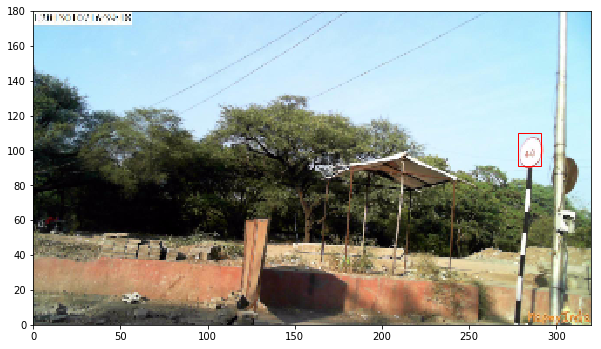

In [19]:
def draw_img_bb(image, bb, bb_pred=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys', interpolation='none', origin='upper', extent=[0, image.shape[1], 0, image.shape[0]])
    if bb_pred:
        plt.gca().add_patch(matplotlib.patches.Rectangle((bb_pred[1], image.shape[0]-bb_pred[0]-bb_pred[3]), bb_pred[2],bb_pred[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(bb_pred, bb)), (bb_pred[1], image.shape[0]-bb_pred[0]-bb_pred[3]+bb_pred[3]+10), color='r')
    plt.gca().add_patch(matplotlib.patches.Rectangle((bb[1], image.shape[0]-bb[0]-bb[3]), bb[2],bb[3], ec='r', fc='none'))
    plt.show()
    
draw_img_bb(images_rescaled[3], bbs_rescaled[3])#, [200, 400, 20,20])

In [ ]:
# weird_imgs = [images_transformed[i] for i in range(len(images_transformed))
#               if images[i].shape != (720,1280,3)]

# print(len(weird_imgs))

# from PIL import Image

# for image in weird_imgs[:3]:
#     image = (image * 255).astype(np.uint8)
#     im = Image.fromarray(image)
#     plt.figure()
#     plt.imshow(im)
#     plt.show()



In [ ]:
# for image in images_transformed[:3]:
#     image = (image * 255).astype(np.uint8)
#     im = Image.fromarray(image)
#     plt.figure()
#     plt.imshow(im)
#     plt.show()



In [ ]:
# # Create images with random rectangles and bounding boxes. 
# num_imgs = 50000

# img_size = 8
# min_object_size = 1
# max_object_size = 4
# num_objects = 1

# bboxes = np.zeros((num_imgs, num_objects, 4))
# imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0

# for i_img in range(num_imgs):
#     for i_object in range(num_objects):
#         w, h = np.random.randint(min_object_size, max_object_size, size=2)
#         x = np.random.randint(0, img_size - w)
#         y = np.random.randint(0, img_size - h)
#         imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
#         bboxes[i_img, i_object] = [x, y, w, h]
        
# imgs.shape, bboxes.shape

In [22]:
X = np.array(images_rescaled)
# # Reshape and normalize the image data to mean 0 and std 1. 
# X = (images_transformed - np.mean(images_transformed)) / np.std(images_transformed)
# X.shape, np.mean(X), np.std(X)

X.shape


(467, 180, 320, 3)

In [23]:
bb = np.array(bbs_rescaled)
bb.shape

(467, 4)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, bb_train, bb_test = train_test_split(X, bb, test_size=0.2, random_state=42)

In [38]:

total_epochs_trained = 0
model = Sequential()
model.add(Conv2D(32, (4, 4), input_shape=(image_size[0],image_size[1],3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

# from keras.optimizers import SGD
# opt = SGD(lr=0.05)

model.compile(loss='mse',
              optimizer='rmsprop')
#               metrics=['mse']) 

# NOTE: If loss=categorical_crossentropy, 
# then 'accuracy' metrics == categorical_accruacy

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 177, 317, 32)      1568      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 88, 158, 32)       0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 88, 158, 32)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 86, 156, 64)       18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 43, 78, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 43, 78, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 41, 76, 32)        18464     
__________

In [ ]:
epochs_per_round = 1
epoch_acc = []
print("IOU+MSE AFTER X EPOCHS:\n")

for i in range(40):
    # fits the model on batches with real-time data augmentation:

    model.fit(X_train, bb_train, epochs=epochs_per_round, batch_size=32, verbose=1)

    total_epochs_trained += epochs_per_round

    pred = model.predict(X_test)

    IOUs = [IOU(pred[i],bb_test[i]) for i in range(len(pred))]
    
    mean_IOU = np.mean(IOUs)

    print("EPOCH #", total_epochs_trained, "(mean IOU):", mean_IOU)
    
    epoch_acc.append((mean_IOU, total_epochs_trained))
    
    


ACCURACY AFTER X EPOCHS:

Epoch 1/1
373/373 [==============================] - 38s 101ms/step - loss: 7046.7101


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

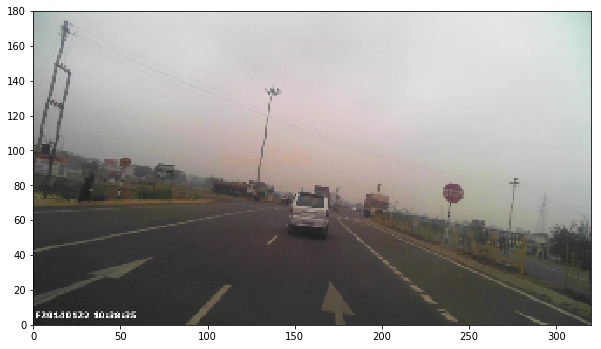

In [27]:
draw_img_bb(X_test[0], bb_test[0], pred[0])

In [33]:
pred

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
